In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [7]:
sales_of_company_x = pd.read_csv("./data/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("./data/monthly-boston-armed-robberies-j.csv")
mean_monthly_temp = pd.read_csv("./data/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("./data/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("./data/daily-total-female-births-in-cal.csv")

In [8]:
all_series = {
    "Monthly sales of company X": sales_of_company_x['Count'],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

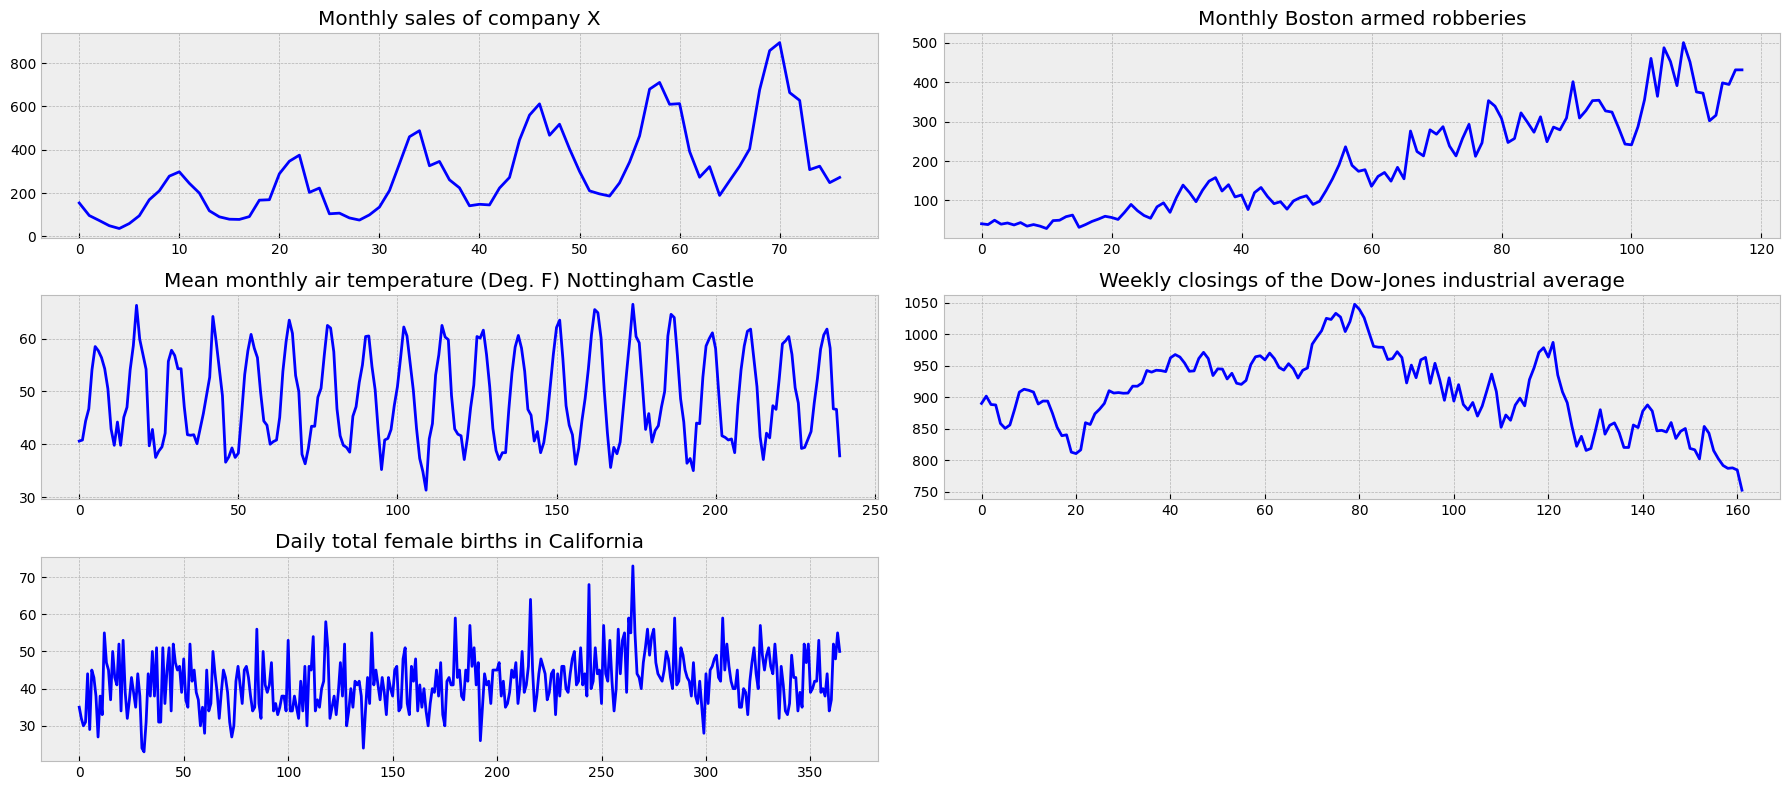

In [9]:
with plt.style.context('bmh'):
    plt.figure(figsize=(18, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
    plt.tight_layout()

In [24]:
def ma(series: pd.Series, windows: int):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(windows).mean()

In [25]:
def ma_predict(series: pd.Series, windows: int, n_pred: int):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-windows:].mean()]), ignore_index=True)
    return new_series

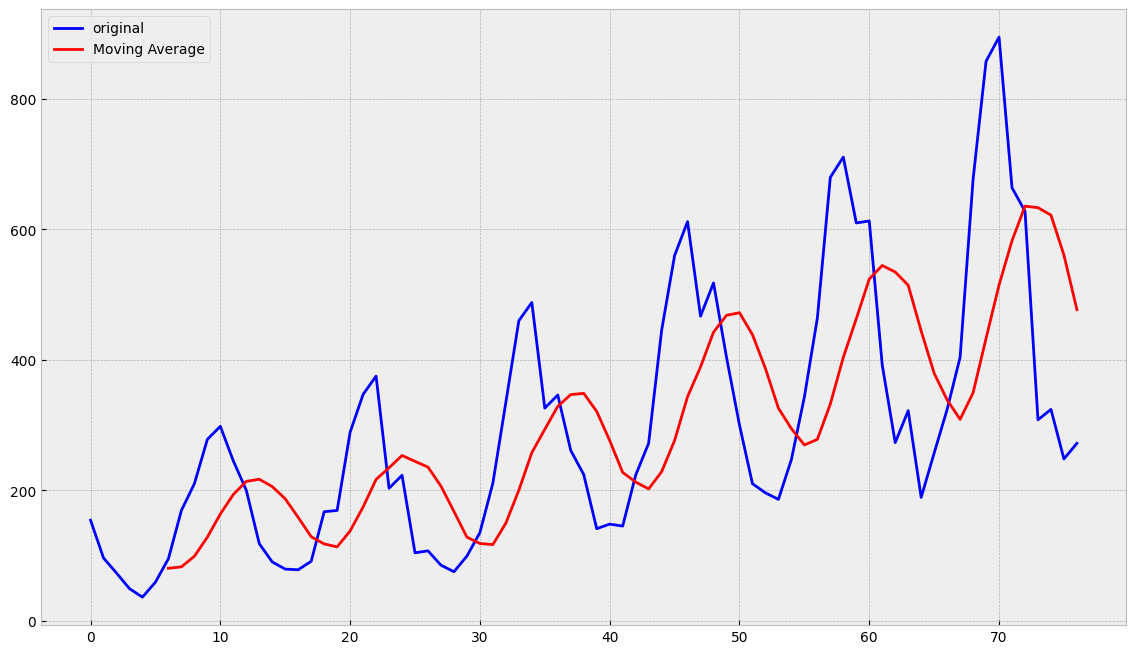

In [26]:
ser = ma(sales_of_company_x["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x['Count'], color='blue', label='original')
    plt.plot(ser, color='red', label='Moving Average')
    plt.legend()

C:\Users\rsv\AppData\Local\Temp\ipykernel_14184\3664917548.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_series = new_series.append(pd.Series([new_series[-windows:].mean()]), ignore_index=True)


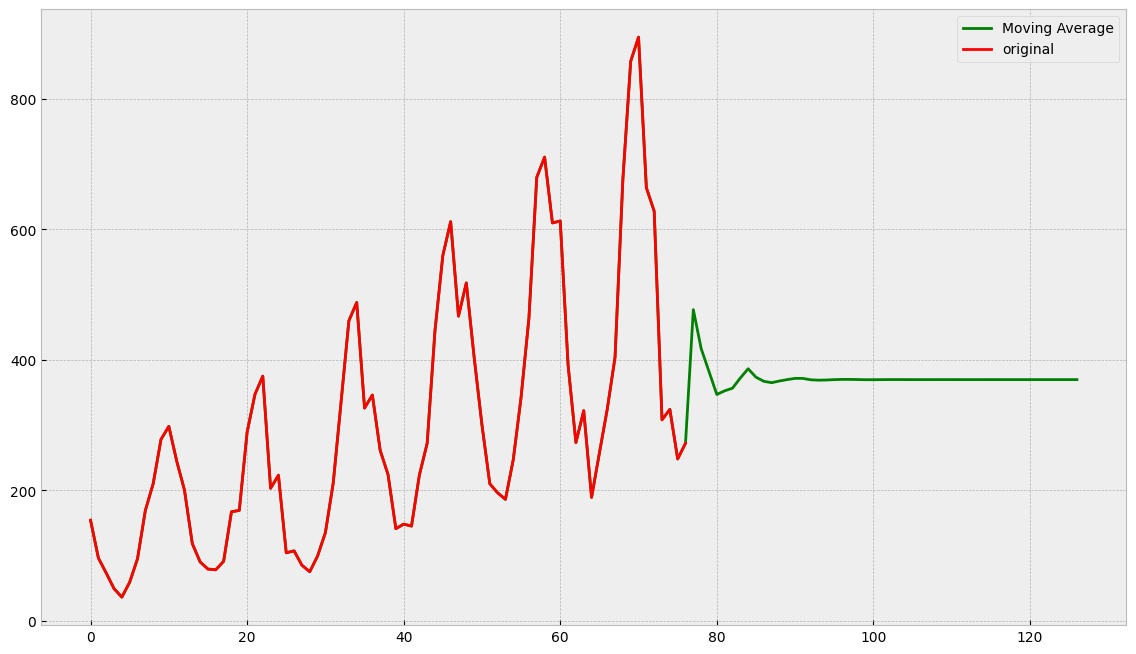

In [20]:
ser_pred = ma_predict(sales_of_company_x["Count"], 7, 50)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ser_pred, color='green', label='Moving Average')
    plt.plot(sales_of_company_x['Count'], color='red', label='original')
    plt.legend()

---
Взвешенная скользящая средняя
---

In [22]:
def wma(series: pd.Series, windows: int, weights: np.array) -> pd.Series:
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(windows).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

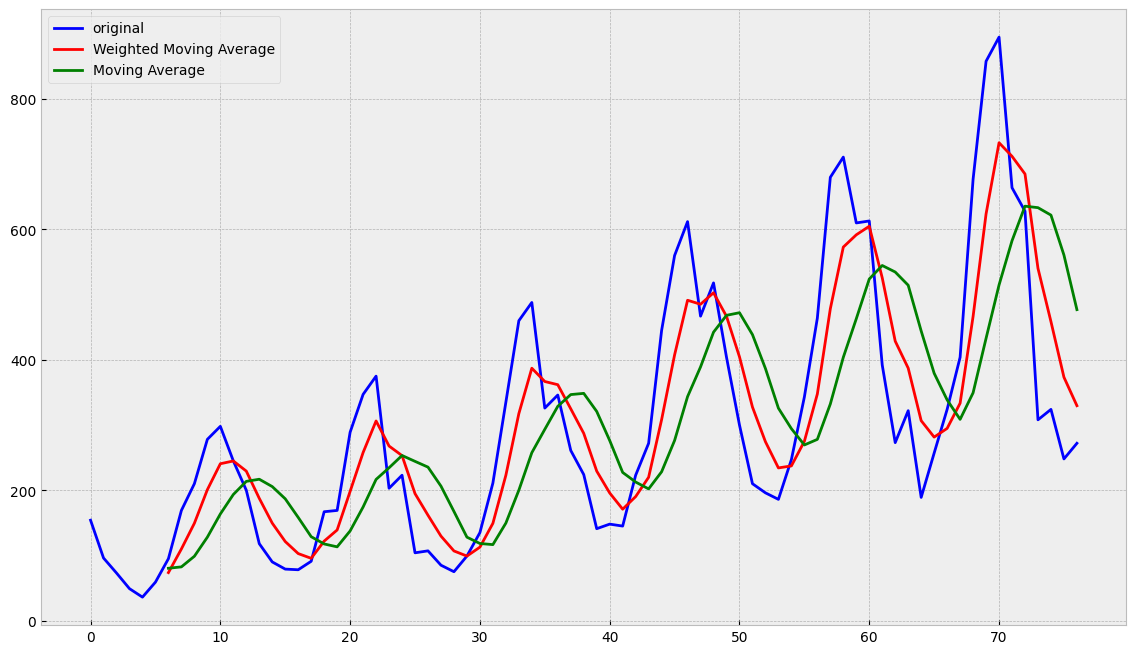

In [27]:
ser_wma = wma(sales_of_company_x["Count"], 7, [1,1,2,3,5,8,13])
ser_ma = ma(sales_of_company_x['Count'], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x['Count'], color='blue', label='original')
    plt.plot(ser_wma, color='red', label='Weighted Moving Average')
    plt.plot(ser_ma, color='green', label='Moving Average')
    plt.legend()

In [28]:
def ema(series: pd.Series, alpha: float ):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

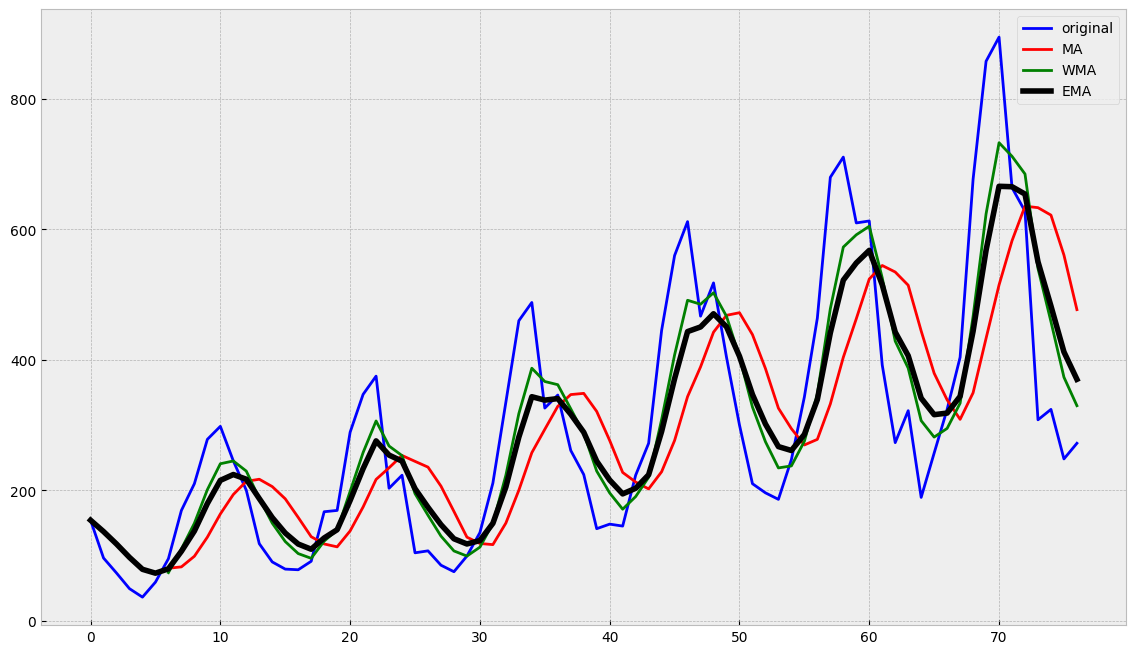

In [29]:
ema = ema(sales_of_company_x["Count"], 0.3)
wma = wma(sales_of_company_x["Count"], 7, [1,1,2,3,5,8,13])
ma = ma(sales_of_company_x["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

In [ ]:
from pandas import ema

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [31]:
series = sales_of_company_x["Count"]
series

0     154
1      96
2      73
3      49
4      36
     ... 
72    628
73    308
74    324
75    248
76    272
Name: Count, Length: 77, dtype: int64

In [32]:
train, test, val = series[:60], series[60:70], series[70:]

In [ ]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error